In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torch.optim.lr_scheduler import _LRScheduler
import random
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import models
from torchsummary import summary
import torch.nn.functional as F


/home/MMI24limbyungwan/.conda/envs/byungwan_resn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

print(os.environ.get('CUDA_VISIBLE_DEVICES'))

cuda
3


In [3]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 클래스별 IoU를 계산하기 위한 함수
def calculate_iou_per_class(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    iou = intersection / union if union > 0 else 0
    return iou

def normalize_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 이미지를 0과 1 사이의 값으로 스케일 조정
    #image = image.to(torch.float)
    normalized_image = image / 255.0
    normalized_image = (normalized_image - mean) / std

    return normalized_image


In [4]:
def make_bumper(image, mask):
    h,w,c = image.shape
    center = (w//2, int(h*0.375))  # x,y
    axis_length = (w//2, int(h*0.64))  # 장축 반지름과 단축 반지름

    # 타원 그리기 (타원을 1로 채우고 나머지 부분은 0으로 채움)
    oval = np.zeros((h,w,1),dtype=np.uint8)
    cv2.ellipse(oval, center, axis_length, 0, 0, 360, 1, -1)

    num_bumper = random.randint(0,2922)
    target_image_path = (f'./data/224/train_target_image/TRAIN_TARGET_{num_bumper:04d}.png')
    #target_image_path = './data/224/train_target_image/TRAIN_TARGET_0001.png'
    target_image = cv2.imread(target_image_path, cv2.IMREAD_COLOR)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
    target_image = normalize_image(target_image)

    mixed_image = image * oval + target_image * (1-oval)
    mixed_mask = mask * oval[:,:,0] + np.ones_like(mask)*0*(1-oval[:,:,0])

    return mixed_image, mixed_mask

def make_bumper_std(image, mask):
    h,w,_ = image.shape
    background = cv2.imread('./background.png')
    background = cv2.resize(background, (h,w))
    background_mask = background[:,:,0]

    target_image = cv2.imread('./data/224/target_val_image/svm_front_2021-06-04-14-37-37_00000000.png')
    target_image = normalize_image(target_image)

    target_image = cv2.resize(target_image, (h,w))
    
    bumper_image = image * background + target_image * (1-background)
    bumper_mask = mask * background_mask + np.ones_like(mask)*0*(1-background_mask)

    
    return bumper_image, bumper_mask

In [5]:
def calculate_ious(y_true, y_pred, class_num):
    ious = []
    for class_id in range(class_num):
        intersection = np.sum((y_true == class_id) & (y_pred == class_id))
        union = np.sum((y_true == class_id) | (y_pred == class_id))
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    return ious
def apply_fisheye_distortion(images, masks, label):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 2
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    # dist_num = 0
    # if label == 1:
    #     dist_num = random.randint(1,3)
    # elif label == 2.5:
    #     dist_num = 2.5
    if label == 5:
        dist_num = 0
    else:
        dist_num = 2**(label)
    dist_coeffs = np.array([0, 0.03 * dist_num, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    road_k = 0.3

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # 텐서를 NumPy 배열로 변환
        mask = masks[i].cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)

        if label != 5:
            undistorted_image = cv2.resize(undistorted_image[int(height*road_k):int(height*0.85),:], (height, width))
            undistorted_mask = cv2.resize(undistorted_mask[int(height*road_k):int(height*0.85),:], (height, width))

        undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
        undistorted_mask[undistorted_mask > 12] = 12

        undistorted_image = normalize_image(undistorted_image)
        #undistorted_mask = normalize_image(undistorted_mask)
        if label != 5:
            undistorted_image, undistorted_mask = make_bumper(undistorted_image, undistorted_mask)

        #다시 텐서로 변환
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)

        undistorted_images.append(undistorted_image)
        undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    undistorted_masks = torch.stack(undistorted_masks, dim=0)

    return undistorted_images, undistorted_masks


## 데이터셋

In [6]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, CL=0):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.CL = CL

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        directory_path = './data/224'
        img_path = self.data.iloc[idx, 1]
        img_path = os.path.join(directory_path, img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_path = self.data.iloc[idx, 2]
        mask_path = os.path.join(directory_path, mask_path)
        mask = cv2.imread(mask_path)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        if self.CL == 0:
            mask = np.round(mask).astype(np.uint8)
            mask[mask > 12] = 12 #배경을 픽셀값 12로 간주
            mask += 1
            mask[mask == 13] = 0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
     

transform = A.Compose(
    [   
        #A.Resize(224, 224),
        #A.Resize(128, 128),
        #A.Normalize(),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        
        # 변형
        A.HorizontalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        A.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7),
        
        ToTensorV2()
    ]
)

totensor = A.Compose(
    [   
        #A.Resize(224, 224),
        #A.Resize(128, 128),
        #A.Normalize(),
        #A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        
        # 변형
        #A.HorizontalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.HueSaturationValue(p=0.2),
        #A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        
        ToTensorV2()
    ]
)

## 모델 선언

In [7]:
#기본 Conv블럭에 잔차연결 추가
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ConvBlock, self).__init__()
        
        # 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Adding the skip connection
        out += self.skip(identity)
        out = self.relu2(out)
        
        return out

#인코더 블럭
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock,self).__init__()
        self.convblock1 = ConvBlock(in_channels, out_channels)  # 첫 번째 ConvBlock의 in_channels는 입력 이미지의 채널 수와 일치해야 합니다.
        #self.convblock2 = ConvBlock(out_channels, out_channels)  # 두 번째 ConvBlock의 in_channels는 out_channels와 일치해야 합니다.
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self,x):
        x = self.convblock1(x)
        #x = self.convblock2(x)
        p = self.maxpool(x)
        return x , p
#디코더 블럭
#디코더는 업샘플링 이후 스킵연결과 붙어서 convblock을 통과해야함
#skip보다 작은 x x먼저 업샘플링 32 -> 64 , skip과 결합 6464 
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock,self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1)#x 업샘플링
        self.convblock1 = ConvBlock(channels*2, channels)#차원감소
        #self.convblock2 = ConvBlock(channels, channels)
    def forward(self,x,skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #x = self.convblock2(x)
        return x

###########################################
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return (grad_output * -1)
    
class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(224*224*4, 10)
        self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = GradReverse.apply(x) # gradient reverse
        x = self.conv(x)
        x = F.leaky_relu(x)
        x = x.view(-1, 224*224*4)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

###########################################


#Unet구조 middle의 xm값의 움직임에 주의
class Residual_Unet(nn.Module):
    def __init__(self,n_classes):
        super(Residual_Unet,self).__init__()
        self.encoder1 = EncoderBlock(3,64)
        self.encoder2 = EncoderBlock(64,128)
        self.encoder3 = EncoderBlock(128,256)
        self.encoder4 = EncoderBlock(256,512)
        
        self.middleconv = ConvBlock(512,1024)
        
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        
        self.domain_classifier = domain_classifier()
                                        

    def forward(self,x):
        x1,p = self.encoder1(x)#3->64   #P:256,256 x1 :512,512
        x2,p = self.encoder2(p)#64->128 #P:128,128 x2:256,256
        x3,p = self.encoder3(p)#128->256#p:64,64 x3:128,128
        x4,p = self.encoder4(p)#256->512#p:32,32 x4:64,64
        
        xm = self.middleconv(p)#512->1024#32,32
        
        x = self.decoder4(xm,x4)#뉴런:1024->512->512 #출력tensor:64,64
        x = self.decoder3(x,x3)#뉴런:512->256->256 #출력tensor:128,128
        x = self.decoder2(x,x2)#뉴런:256->128->128 #출력tensor:256,256
        x = self.decoder1(x,x1)#뉴런:128->64->64 #출력tensor:512,512

        x_c = self.segmap(x)
        x_d = self.domain_classifier(x)
        # print("x_c", x_c.shape)
        # print("x_d", x_d.shape)
        return x_c, x_d

In [8]:
# #기본 Conv블럭에 잔차연결 추가
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ConvBlock, self).__init__()
        
#         # 3x3 convolution
#         self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.bn1 = nn.BatchNorm2d(in_channels)
#         self.relu1 = nn.ReLU()
        
#         # 3x3 convolution
#         self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU()
        
#         # Skip connection
#         self.skip = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.skip = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
        
#     def forward(self, x):
#         identity = x
        
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.conv2(out)
#         out = self.bn2(out)
        
#         # Adding the skip connection
#         out += self.skip(identity)
#         out = self.relu2(out)
        
#         return out

# #인코더 블럭
# class EncoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(EncoderBlock,self).__init__()
#         self.convblock1 = ConvBlock(in_channels, out_channels)  # 첫 번째 ConvBlock의 in_channels는 입력 이미지의 채널 수와 일치해야 합니다.
#         #self.convblock2 = ConvBlock(out_channels, out_channels)  # 두 번째 ConvBlock의 in_channels는 out_channels와 일치해야 합니다.
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self,x):
#         x = self.convblock1(x)
#         #x = self.convblock2(x)
#         p = self.maxpool(x)
#         return x , p
# #디코더 블럭
# #디코더는 업샘플링 이후 스킵연결과 붙어서 convblock을 통과해야함
# #skip보다 작은 x x먼저 업샘플링 32 -> 64 , skip과 결합 6464 
# class DecoderBlock(nn.Module):
#     def __init__(self, channels):
#         super(DecoderBlock,self).__init__()
#         self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1)#x 업샘플링
#         self.convblock1 = ConvBlock(channels*2, channels)#차원감소
#         #self.convblock2 = ConvBlock(channels, channels)
#     def forward(self,x,skip):
#         x = self.upsample(x)
#         x = torch.cat([x, skip], dim=1)
#         x = self.convblock1(x)
#         #x = self.convblock2(x)
#         return x

# ###########################################
# class GradReverse(torch.autograd.Function):
#     @staticmethod
#     def forward(self, x):
#         return x.view_as(x)
#     @staticmethod
#     def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
#         return (grad_output * -1)

# class domain_classifier(nn.Module):
#     def __init__(self):
#         super(domain_classifier, self).__init__()
        
#         self.conv = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0)
#         self.fc1 = nn.Linear(224*224*4, 10)
#         self.fc2 = nn.Linear(10, 4) # source = 0, target = 1 회귀 가정
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
        
#         x = GradReverse.apply(x) # gradient reverse
#         x = self.conv(x)
#         x = F.leaky_relu(x)
#         x = x.view(-1, 224*224*4)
#         x = F.leaky_relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

# ###########################################


# #Unet구조 middle의 xm값의 움직임에 주의
# class Residual_Unet_mid(nn.Module):
#     def __init__(self,n_classes):
#         super(Residual_Unet_mid,self).__init__()
#         self.encoder1 = EncoderBlock(3,64)
#         self.encoder2 = EncoderBlock(64,128)
#         self.encoder3 = EncoderBlock(128,256)
#         # self.encoder4 = EncoderBlock(256,512)
        
#         self.middleconv = ConvBlock(256,512)
        
#         # self.decoder4 = DecoderBlock(512)
#         self.decoder3 = DecoderBlock(256)
#         self.decoder2 = DecoderBlock(128)
#         self.decoder1 = DecoderBlock(64)
#         self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        
#         self.domain_classifier = domain_classifier()
                                        

#     def forward(self,x):
#         x1,p = self.encoder1(x)#3->64   #P:256,256 x1 :512,512
#         x2,p = self.encoder2(p)#64->128 #P:128,128 x2:256,256
#         x3,p = self.encoder3(p)#128->256#p:64,64 x3:128,128
#         # x4,p = self.encoder4(p)#256->512#p:32,32 x4:64,64
        
#         xm = self.middleconv(p)#512->1024#32,32
        
#         # x = self.decoder4(xm,x4)#뉴런:1024->512->512 #출력tensor:64,64
#         x = self.decoder3(xm,x3)#뉴런:512->256->256 #출력tensor:128,128
#         x = self.decoder2(x,x2)#뉴런:256->128->128 #출력tensor:256,256
#         x = self.decoder1(x,x1)#뉴런:128->64->64 #출력tensor:512,512

#         x_c = self.segmap(x)
#         x_d = self.domain_classifier(x)
#         # print("x_c", x_c.shape)
#         # print("x_d", x_d.shape)
#         return x_c, x_d

## Loss Function

In [9]:
# loss function과 optimizer 정의
class DANN_Loss(nn.Module):
    def __init__(self):
        super(DANN_Loss, self).__init__()
        self.CE = nn.CrossEntropyLoss()

    def forward(self, result, label, domain_num, alpha=1):
        label_logits, domain_logits = result
        batch_size = domain_logits.shape[0]

        segment_loss = self.CE(label_logits, label)
        
        domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
        domain_loss = self.CE(domain_logits, domain_target)
        
        loss = segment_loss + alpha * domain_loss

        return loss, segment_loss, domain_loss
    
    

class DANN_Loss_mse(nn.Module):
    def __init__(self):
        super(DANN_Loss_mse, self).__init__()
        self.CE = nn.CrossEntropyLoss()
        self.MSE = nn.MSELoss()

    def forward(self, result, label, domain_num, alpha = 1):
        label_logits, domain_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]

        segment_loss = self.CE(label_logits, label) # class 분류 loss
        
        domain_target = torch.LongTensor([domain_num] * batch_size).unsqueeze(1).to(device).float()      
        domain_loss = self.MSE(domain_logits, domain_target) # domain 분류 loss
        domain_loss = torch.sqrt(domain_loss)
        loss = segment_loss + alpha * domain_loss
        # print("segment_mask : ", label.shape)
        # print("domain_answer : ", domain_target.shape)
        return loss ,segment_loss, domain_loss


loss_fn = DANN_Loss().to(device)
#loss_fn = DANN_Loss_mse().to(device)

#criterion =nn.CrossEntropyLoss()
#domain_criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Parameters , Train

In [11]:
LR = 0.0001
EP = 40
BATCH_SIZE = 16
ACCMULATION_STEP = 1 
N_CLASSES = 13
alpha = 0.01
N_LABELS = 4
# model 초기화


In [12]:
#모델 선언
model = Residual_Unet(n_classes = N_CLASSES).to(device)
#model.load_state_dict(torch.load('./data/resnet34_1118_1.pth'), strict=False)
#옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer.zero_grad() 
#데이터 로더
source_dataset = CustomDataset(csv_file='./data/896_csv/train_source.csv', transform=transform)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
#소스변형
val_source_dataset = CustomDataset(csv_file="./data/896_csv/val_source.csv", transform=transform)
val_source_dataloader = DataLoader(val_source_dataset, batch_size=BATCH_SIZE, shuffle=False)
#실제 타겟
val_target_dataset = CustomDataset(csv_file="./data/896_csv/val_source_CL.csv", transform=totensor, CL=1)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 모델의 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 수: {total_params}")

총 파라미터 수: 42763422


miou test

In [13]:
for epoch in range(EP):
    model.train()
    epoch_loss = 0
    seg_losses = 0
    domain_losses = 0
    #alpha = 0.0045
    train_class_ious = [[],[],[],[]]
    
    # label_dfs = {label: None for label in range(N_LABELS)}
    # print(alpha)
    for source_images, source_masks in tqdm(source_dataloader,desc=f"Epoch: {epoch+1}"):
        for label in range(N_LABELS): 
            source_image, source_mask = apply_fisheye_distortion(source_images, source_masks, label)
            source_image = source_image.float().to(device)
            source_mask = source_mask.long().to(device)
            source_outputs = model(source_image)

            optimizer.zero_grad()
            target_loss, seg_loss, domain_loss = loss_fn(source_outputs, source_mask, label, alpha = alpha)
            epoch_loss += target_loss.item()
            seg_losses +=  seg_loss.item()
            domain_losses += domain_loss.item()
            target_loss.backward()
            optimizer.step()
            # miou측정
            source_outputs = model(source_image)
            source_outputs = torch.softmax(source_outputs[0], dim=1).cpu()
            source_outputs = torch.argmax(source_outputs, dim=1).numpy()
            
            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(source_mask.cpu()), np.array(source_outputs), class_id)
                train_class_ious[label].append(iou)
            
    for i in range(N_LABELS):
        buff = np.array(train_class_ious[i]).reshape(-1,N_CLASSES)
        buff = np.mean(buff, axis=0)
        print(f"\nLabel_{i}: IoU Scores Train")
        for class_id, iou in enumerate(buff):
            print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
            if (class_id+1) % 7 == 0:
                print()   
    print()    
    print(f"Train seg Loss: {(seg_losses/(N_LABELS*len(source_dataloader)))}",f"Train dom Loss: {(domain_losses/(N_LABELS*len(source_dataloader)))}")
    print(f"Train Loss: {(epoch_loss/(N_LABELS*len(source_dataloader)))}")
    print(f"Train mIoU: {np.mean(train_class_ious)}" )
    ################################################################
    # 클래스별 IoU를 누적할 리스트 초기화
    val_class_ious = []
    fish_val_class_ious = []
    val_epoch_loss = 0
    val_seg_loss = 0
    val_domain_loss = 0
    # valid
    model.eval()
    with torch.no_grad():
        for target_images, target_masks in tqdm(val_source_dataloader):
            label = 5
            target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
            target_images = target_images.float().to(device)
            target_masks = target_masks.long().to(device)

            target_outputs = model(target_images)

            target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, 1.5, alpha = alpha)

            val_seg_loss +=  target_seg_loss.item()
            val_domain_loss += target_domain_loss.item()
            
            loss = target_loss

            val_epoch_loss += loss.item()

            # train 클래스별 IoU 계산
            target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
            target_outputs = torch.argmax(target_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
                fish_val_class_ious.append(iou)

    fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1,N_CLASSES)
    fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
    print()
    print("--IoU Scores Source val--")
    for class_id, iou in enumerate(fish_val_class_ious):
        print(f'Class{class_id}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    fish_val_mIoU = np.mean(fish_val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Valid_Seg Loss: {(val_seg_loss/len(val_source_dataloader))}",f"Valid_dom Loss: {(val_domain_loss/len(val_source_dataloader))}")
    print(f"Valid Source Loss: {(val_epoch_loss/len(val_source_dataloader))}")
    print(f"Valid Source mIoU: {fish_val_mIoU}" )
    print("___________________________________________________________________________________________\n")
    val_class_ious = []
    fish_val_class_ious = []
    val_epoch_loss = 0
    val_seg_loss = 0
    val_domain_loss = 0
    with torch.no_grad():
        for target_images, target_masks in tqdm(val_target_dataloader):
            label = 5
            target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
            target_images = target_images.float().to(device)
            target_masks = target_masks.long().to(device)

            target_outputs = model(target_images)

            target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, 1.5, alpha = alpha)

            val_seg_loss +=  target_seg_loss.item()
            val_domain_loss += target_domain_loss.item()
            
            loss = target_loss

            val_epoch_loss += loss.item()

            # train 클래스별 IoU 계산
            target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
            target_outputs = torch.argmax(target_outputs, dim=1).numpy()

            for class_id in range(N_CLASSES):
                iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
                fish_val_class_ious.append(iou)

    fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1,N_CLASSES)
    fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
    print()
    print("--IoU Scores Target val--")
    for class_id, iou in enumerate(fish_val_class_ious):
        print(f'Class{class_id}: {iou:.4f}', end=" ")
        if (class_id+1) % 7 == 0:
            print()

    # mIoU 계산
    fish_val_mIoU = np.mean(fish_val_class_ious)

    # 에폭마다 결과 출력 
    print(f"\nEpoch{epoch+1}")
    print(f"Valid_Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Valid_dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
    print(f"Valid Target Loss: {(val_epoch_loss/len(val_target_dataloader))}")
    print(f"Valid Target mIoU: {fish_val_mIoU}" )
    print("___________________________________________________________________________________________\n")
print("Hyperparamerters")
print(f"LR = {LR} | EP = {EP}, BATCH_SIZE = {BATCH_SIZE}, N_CLASSES = {N_CLASSES}, init_alpha = {alpha}, N_LABELS = {N_LABELS}")

Epoch: 1: 100%|██████████| 138/138 [13:15<00:00,  5.77s/it]



Label_0: IoU Scores Train
Class00: 0.9237 Class01: 0.7432 Class02: 0.0103 Class03: 0.4320 Class04: 0.0418 Class05: 0.0000 Class06: 0.0001 
Class07: 0.0177 Class08: 0.4909 Class09: 0.7202 Class10: 0.0000 Class11: 0.0000 Class12: 0.4174 
Label_1: IoU Scores Train
Class00: 0.9333 Class01: 0.7531 Class02: 0.0101 Class03: 0.4490 Class04: 0.0431 Class05: 0.0000 Class06: 0.0001 
Class07: 0.0170 Class08: 0.5051 Class09: 0.7376 Class10: 0.0000 Class11: 0.0000 Class12: 0.4415 
Label_2: IoU Scores Train
Class00: 0.9476 Class01: 0.7574 Class02: 0.0104 Class03: 0.4651 Class04: 0.0436 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0167 Class08: 0.5200 Class09: 0.7511 Class10: 0.0000 Class11: 0.0000 Class12: 0.4626 
Label_3: IoU Scores Train
Class00: 0.9554 Class01: 0.7555 Class02: 0.0103 Class03: 0.4768 Class04: 0.0458 Class05: 0.0000 Class06: 0.0000 
Class07: 0.0161 Class08: 0.5307 Class09: 0.7632 Class10: 0.0000 Class11: 0.0000 Class12: 0.4784 
Train seg Loss: 0.8391990267496178 Train dom Loss: 1.84

  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_4027465/2390578588.py:13: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 30/30 [00:34<00:00,  1.15s/it]



--IoU Scores Source val--
Class0: 0.3676 Class1: 0.3262 Class2: 0.0036 Class3: 0.3857 Class4: 0.0274 Class5: 0.0000 Class6: 0.0003 
Class7: 0.0744 Class8: 0.4582 Class9: 0.8600 Class10: 0.0000 Class11: 0.0000 Class12: 0.1745 
Epoch1
Valid_Seg Loss: 1.5902826031049093 Valid_dom Loss: 1.3123546282450358
Valid Source Loss: 1.6034061511357625
Valid Source mIoU: 0.20599385934824072
___________________________________________________________________________________________



100%|██████████| 61/61 [01:08<00:00,  1.13s/it]



--IoU Scores Target val--
Class0: 0.6064 Class1: 0.1572 Class2: 0.0003 Class3: 0.1807 Class4: 0.0322 Class5: 0.0000 Class6: 0.0001 
Class7: 0.0044 Class8: 0.3640 Class9: 0.5769 Class10: 0.0000 Class11: 0.0000 Class12: 0.0491 
Epoch1
Valid_Seg Loss: 2.2386508632878788 Valid_dom Loss: 1.384768742029784
Valid Target Loss: 2.252498562218713
Valid Target mIoU: 0.15164564069341818
___________________________________________________________________________________________



Epoch: 2: 100%|██████████| 138/138 [11:42<00:00,  5.09s/it]



Label_0: IoU Scores Train
Class00: 0.9535 Class01: 0.8140 Class02: 0.0861 Class03: 0.5174 Class04: 0.2016 Class05: 0.0000 Class06: 0.0035 
Class07: 0.0461 Class08: 0.5858 Class09: 0.8001 Class10: 0.0000 Class11: 0.0000 Class12: 0.6046 
Label_1: IoU Scores Train
Class00: 0.9584 Class01: 0.8197 Class02: 0.0955 Class03: 0.5348 Class04: 0.2108 Class05: 0.0000 Class06: 0.0032 
Class07: 0.0431 Class08: 0.6010 Class09: 0.8095 Class10: 0.0000 Class11: 0.0000 Class12: 0.6334 
Label_2: IoU Scores Train
Class00: 0.9650 Class01: 0.8230 Class02: 0.1028 Class03: 0.5527 Class04: 0.2216 Class05: 0.0000 Class06: 0.0028 
Class07: 0.0437 Class08: 0.6177 Class09: 0.8183 Class10: 0.0000 Class11: 0.0000 Class12: 0.6566 
Label_3: IoU Scores Train
Class00: 0.9686 Class01: 0.8209 Class02: 0.1060 Class03: 0.5652 Class04: 0.2320 Class05: 0.0000 Class06: 0.0023 
Class07: 0.0434 Class08: 0.6278 Class09: 0.8262 Class10: 0.0000 Class11: 0.0000 Class12: 0.6713 
Train seg Loss: 0.6442109852273395 Train dom Loss: 1.38

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]



--IoU Scores Source val--
Class0: 0.3044 Class1: 0.0411 Class2: 0.0035 Class3: 0.3265 Class4: 0.0006 Class5: 0.0000 Class6: 0.0148 
Class7: 0.1452 Class8: 0.1591 Class9: 0.5631 Class10: 0.0000 Class11: 0.0000 Class12: 0.1235 
Epoch2
Valid_Seg Loss: 2.6405162175496417 Valid_dom Loss: 4.13847017288208
Valid Source Loss: 2.681900938351949
Valid Source mIoU: 0.12935777893399122
___________________________________________________________________________________________



100%|██████████| 61/61 [01:11<00:00,  1.17s/it]



--IoU Scores Target val--
Class0: 0.6376 Class1: 0.0676 Class2: 0.0037 Class3: 0.1774 Class4: 0.0090 Class5: 0.0000 Class6: 0.0095 
Class7: 0.0024 Class8: 0.0777 Class9: 0.3673 Class10: 0.0000 Class11: 0.0000 Class12: 0.0436 
Epoch2
Valid_Seg Loss: 3.4094745174783174 Valid_dom Loss: 14.075603485107422
Valid Target Loss: 3.5502305460757895
Valid Target mIoU: 0.10737104232165674
___________________________________________________________________________________________



Epoch: 3: 100%|██████████| 138/138 [11:33<00:00,  5.02s/it]



Label_0: IoU Scores Train
Class00: 0.9577 Class01: 0.8423 Class02: 0.1754 Class03: 0.5775 Class04: 0.3034 Class05: 0.0000 Class06: 0.0187 
Class07: 0.0569 Class08: 0.6378 Class09: 0.8273 Class10: 0.0000 Class11: 0.0000 Class12: 0.6941 
Label_1: IoU Scores Train
Class00: 0.9617 Class01: 0.8466 Class02: 0.1953 Class03: 0.5952 Class04: 0.3149 Class05: 0.0005 Class06: 0.0167 
Class07: 0.0535 Class08: 0.6512 Class09: 0.8344 Class10: 0.0000 Class11: 0.0000 Class12: 0.7194 
Label_2: IoU Scores Train
Class00: 0.9671 Class01: 0.8493 Class02: 0.1988 Class03: 0.6123 Class04: 0.3303 Class05: 0.0001 Class06: 0.0157 
Class07: 0.0554 Class08: 0.6667 Class09: 0.8402 Class10: 0.0000 Class11: 0.0000 Class12: 0.7390 
Label_3: IoU Scores Train
Class00: 0.9704 Class01: 0.8482 Class02: 0.2068 Class03: 0.6234 Class04: 0.3402 Class05: 0.0000 Class06: 0.0148 
Class07: 0.0559 Class08: 0.6755 Class09: 0.8457 Class10: 0.0000 Class11: 0.0000 Class12: 0.7511 
Train seg Loss: 0.554075972703488 Train dom Loss: 1.255

100%|██████████| 30/30 [00:37<00:00,  1.24s/it]



--IoU Scores Source val--
Class0: 0.2405 Class1: 0.0296 Class2: 0.0349 Class3: 0.3152 Class4: 0.0002 Class5: 0.0000 Class6: 0.0366 
Class7: 0.1222 Class8: 0.2732 Class9: 0.5345 Class10: 0.0000 Class11: 0.0000 Class12: 0.1069 
Epoch3
Valid_Seg Loss: 3.242388304074605 Valid_dom Loss: 2.367524838447571
Valid Source Loss: 3.2660635630289714
Valid Source mIoU: 0.13029063435544405
___________________________________________________________________________________________



100%|██████████| 61/61 [01:04<00:00,  1.05s/it]



--IoU Scores Target val--
Class0: 0.6780 Class1: 0.0156 Class2: 0.0311 Class3: 0.1711 Class4: 0.0083 Class5: 0.0000 Class6: 0.0127 
Class7: 0.0031 Class8: 0.0780 Class9: 0.3605 Class10: 0.0000 Class11: 0.0000 Class12: 0.0318 
Epoch3
Valid_Seg Loss: 3.8469948104170504 Valid_dom Loss: 2.444932527229434
Valid Target Loss: 3.8714441236902455
Valid Target mIoU: 0.10693610406880727
___________________________________________________________________________________________



Epoch: 4: 100%|██████████| 138/138 [17:04<00:00,  7.43s/it]



Label_0: IoU Scores Train
Class00: 0.9059 Class01: 0.8201 Class02: 0.1347 Class03: 0.5535 Class04: 0.2225 Class05: 0.0000 Class06: 0.0033 
Class07: 0.0195 Class08: 0.6115 Class09: 0.7965 Class10: 0.0000 Class11: 0.0000 Class12: 0.6819 
Label_1: IoU Scores Train
Class00: 0.9157 Class01: 0.8237 Class02: 0.1395 Class03: 0.5695 Class04: 0.2287 Class05: 0.0000 Class06: 0.0030 
Class07: 0.0183 Class08: 0.6217 Class09: 0.8032 Class10: 0.0000 Class11: 0.0000 Class12: 0.7040 
Label_2: IoU Scores Train
Class00: 0.9309 Class01: 0.8263 Class02: 0.1480 Class03: 0.5844 Class04: 0.2356 Class05: 0.0000 Class06: 0.0028 
Class07: 0.0186 Class08: 0.6373 Class09: 0.8107 Class10: 0.0000 Class11: 0.0000 Class12: 0.7217 
Label_3: IoU Scores Train
Class00: 0.9356 Class01: 0.8243 Class02: 0.1532 Class03: 0.5936 Class04: 0.2413 Class05: 0.0000 Class06: 0.0027 
Class07: 0.0187 Class08: 0.6433 Class09: 0.8147 Class10: 0.0000 Class11: 0.0000 Class12: 0.7295 
Train seg Loss: 0.6367934068691903 Train dom Loss: 13.0

100%|██████████| 30/30 [00:42<00:00,  1.41s/it]



--IoU Scores Source val--
Class0: 0.5570 Class1: 0.3461 Class2: 0.0000 Class3: 0.3060 Class4: 0.0030 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0842 Class8: 0.5142 Class9: 0.8295 Class10: 0.0000 Class11: 0.0000 Class12: 0.2591 
Epoch4
Valid_Seg Loss: 1.0452588180700937 Valid_dom Loss: 1.2586506923039755
Valid Source Loss: 1.0578453282515208
Valid Source mIoU: 0.22301366517714435
___________________________________________________________________________________________



100%|██████████| 61/61 [00:38<00:00,  1.57it/s]



--IoU Scores Target val--
Class0: 0.6103 Class1: 0.6718 Class2: 0.0000 Class3: 0.1542 Class4: 0.0048 Class5: 0.0000 Class6: 0.0000 
Class7: 0.0016 Class8: 0.3348 Class9: 0.8094 Class10: 0.0000 Class11: 0.0000 Class12: 0.0770 
Epoch4
Valid_Seg Loss: 1.0230629092357197 Valid_dom Loss: 1.2073710707367444
Valid Target Loss: 1.0351366215064877
Valid Target mIoU: 0.20490891465325947
___________________________________________________________________________________________



Epoch: 5: 100%|██████████| 138/138 [11:53<00:00,  5.17s/it]



Label_0: IoU Scores Train
Class00: 0.9565 Class01: 0.8604 Class02: 0.2448 Class03: 0.6301 Class04: 0.3529 Class05: 0.0000 Class06: 0.0023 
Class07: 0.0517 Class08: 0.6825 Class09: 0.8399 Class10: 0.0000 Class11: 0.0000 Class12: 0.7576 
Label_1: IoU Scores Train
Class00: 0.9599 Class01: 0.8628 Class02: 0.2507 Class03: 0.6450 Class04: 0.3584 Class05: 0.0000 Class06: 0.0019 
Class07: 0.0486 Class08: 0.6898 Class09: 0.8445 Class10: 0.0000 Class11: 0.0000 Class12: 0.7742 
Label_2: IoU Scores Train
Class00: 0.9674 Class01: 0.8646 Class02: 0.2682 Class03: 0.6602 Class04: 0.3681 Class05: 0.0000 Class06: 0.0016 
Class07: 0.0500 Class08: 0.7033 Class09: 0.8489 Class10: 0.0000 Class11: 0.0000 Class12: 0.7886 
Label_3: IoU Scores Train
Class00: 0.9721 Class01: 0.8652 Class02: 0.2809 Class03: 0.6680 Class04: 0.3786 Class05: 0.0000 Class06: 0.0013 
Class07: 0.0493 Class08: 0.7111 Class09: 0.8532 Class10: 0.0000 Class11: 0.0000 Class12: 0.7942 
Train seg Loss: 0.5010871500640676 Train dom Loss: 2.35

100%|██████████| 30/30 [00:18<00:00,  1.64it/s]



--IoU Scores Source val--
Class0: 0.3932 Class1: 0.0746 Class2: 0.0220 Class3: 0.3030 Class4: 0.0029 Class5: 0.0000 Class6: 0.0058 
Class7: 0.1434 Class8: 0.4664 Class9: 0.7774 Class10: 0.0000 Class11: 0.0000 Class12: 0.1945 
Epoch5
Valid_Seg Loss: 2.142837897936503 Valid_dom Loss: 1.5922129233678182
Valid Source Loss: 2.1587600350379943
Valid Source mIoU: 0.18333705447620605
___________________________________________________________________________________________



100%|██████████| 61/61 [00:35<00:00,  1.70it/s]



--IoU Scores Target val--
Class0: 0.7156 Class1: 0.1807 Class2: 0.0051 Class3: 0.1811 Class4: 0.0038 Class5: 0.0000 Class6: 0.0069 
Class7: 0.0035 Class8: 0.2902 Class9: 0.8327 Class10: 0.0000 Class11: 0.0000 Class12: 0.0610 
Epoch5
Valid_Seg Loss: 2.4269882518737043 Valid_dom Loss: 1.8435989266536275
Valid Target Loss: 2.445424242097823
Valid Target mIoU: 0.1754259033361551
___________________________________________________________________________________________



Epoch: 6: 100%|██████████| 138/138 [11:20<00:00,  4.93s/it]



Label_0: IoU Scores Train
Class00: 0.9663 Class01: 0.8757 Class02: 0.3140 Class03: 0.6757 Class04: 0.4039 Class05: 0.0000 Class06: 0.0140 
Class07: 0.0941 Class08: 0.7083 Class09: 0.8565 Class10: 0.0000 Class11: 0.0000 Class12: 0.7979 
Label_1: IoU Scores Train
Class00: 0.9675 Class01: 0.8775 Class02: 0.3286 Class03: 0.6888 Class04: 0.4090 Class05: 0.0001 Class06: 0.0122 
Class07: 0.0879 Class08: 0.7155 Class09: 0.8598 Class10: 0.0000 Class11: 0.0000 Class12: 0.8113 
Label_2: IoU Scores Train
Class00: 0.9718 Class01: 0.8796 Class02: 0.3373 Class03: 0.7010 Class04: 0.4192 Class05: 0.0000 Class06: 0.0095 
Class07: 0.0909 Class08: 0.7264 Class09: 0.8627 Class10: 0.0000 Class11: 0.0000 Class12: 0.8205 
Label_3: IoU Scores Train
Class00: 0.9763 Class01: 0.8815 Class02: 0.3462 Class03: 0.7053 Class04: 0.4279 Class05: 0.0000 Class06: 0.0075 
Class07: 0.0915 Class08: 0.7315 Class09: 0.8664 Class10: 0.0000 Class11: 0.0000 Class12: 0.8228 
Train seg Loss: 0.44520476741203363 Train dom Loss: 1.4

100%|██████████| 30/30 [00:14<00:00,  2.12it/s]



--IoU Scores Source val--
Class0: 0.3500 Class1: 0.5325 Class2: 0.0705 Class3: 0.4053 Class4: 0.0286 Class5: 0.0018 Class6: 0.0201 
Class7: 0.1309 Class8: 0.6395 Class9: 0.6678 Class10: 0.0000 Class11: 0.0000 Class12: 0.3932 
Epoch6
Valid_Seg Loss: 1.3050349950790405 Valid_dom Loss: 1.3998592376708985
Valid Source Loss: 1.3190335790316263
Valid Source mIoU: 0.2492484559792268
___________________________________________________________________________________________



100%|██████████| 61/61 [00:27<00:00,  2.21it/s]



--IoU Scores Target val--
Class0: 0.6157 Class1: 0.2512 Class2: 0.0121 Class3: 0.1603 Class4: 0.0189 Class5: 0.0022 Class6: 0.0060 
Class7: 0.0025 Class8: 0.3266 Class9: 0.4937 Class10: 0.0000 Class11: 0.0000 Class12: 0.1594 
Epoch6
Valid_Seg Loss: 2.3378749538640506 Valid_dom Loss: 1.4123848383543922
Valid Target Loss: 2.351998802091255
Valid Target mIoU: 0.15758226197954603
___________________________________________________________________________________________



Epoch: 7: 100%|██████████| 138/138 [11:02<00:00,  4.80s/it]



Label_0: IoU Scores Train
Class00: 0.9699 Class01: 0.8868 Class02: 0.3615 Class03: 0.6974 Class04: 0.4170 Class05: 0.0003 Class06: 0.0231 
Class07: 0.1338 Class08: 0.7252 Class09: 0.8645 Class10: 0.0001 Class11: 0.0000 Class12: 0.8092 
Label_1: IoU Scores Train
Class00: 0.9714 Class01: 0.8876 Class02: 0.3760 Class03: 0.7130 Class04: 0.4261 Class05: 0.0017 Class06: 0.0195 
Class07: 0.1258 Class08: 0.7340 Class09: 0.8675 Class10: 0.0001 Class11: 0.0000 Class12: 0.8241 
Label_2: IoU Scores Train
Class00: 0.9747 Class01: 0.8897 Class02: 0.3827 Class03: 0.7260 Class04: 0.4374 Class05: 0.0004 Class06: 0.0162 
Class07: 0.1299 Class08: 0.7447 Class09: 0.8709 Class10: 0.0002 Class11: 0.0000 Class12: 0.8344 
Label_3: IoU Scores Train
Class00: 0.9789 Class01: 0.8911 Class02: 0.3855 Class03: 0.7311 Class04: 0.4460 Class05: 0.0002 Class06: 0.0140 
Class07: 0.1296 Class08: 0.7489 Class09: 0.8748 Class10: 0.0001 Class11: 0.0000 Class12: 0.8365 
Train seg Loss: 0.41504356389244396 Train dom Loss: 1.3

100%|██████████| 30/30 [00:17<00:00,  1.68it/s]



--IoU Scores Source val--
Class0: 0.1400 Class1: 0.2931 Class2: 0.0574 Class3: 0.3302 Class4: 0.0052 Class5: 0.0002 Class6: 0.0407 
Class7: 0.0958 Class8: 0.4659 Class9: 0.3361 Class10: 0.0002 Class11: 0.0000 Class12: 0.1858 
Epoch7
Valid_Seg Loss: 2.828503942489624 Valid_dom Loss: 1.3476448059082031
Valid Source Loss: 2.8419803937276202
Valid Source mIoU: 0.15004571696696437
___________________________________________________________________________________________



100%|██████████| 61/61 [00:33<00:00,  1.81it/s]



--IoU Scores Target val--
Class0: 0.7227 Class1: 0.2640 Class2: 0.0320 Class3: 0.1966 Class4: 0.0041 Class5: 0.0002 Class6: 0.0157 
Class7: 0.0024 Class8: 0.1861 Class9: 0.3589 Class10: 0.0001 Class11: 0.0000 Class12: 0.0724 
Epoch7
Valid_Seg Loss: 3.039753081368618 Valid_dom Loss: 1.376820577949774
Valid Target Loss: 3.053521295062831
Valid Target mIoU: 0.14269946009524165
___________________________________________________________________________________________



Epoch: 8: 100%|██████████| 138/138 [11:58<00:00,  5.21s/it]



Label_0: IoU Scores Train
Class00: 0.9726 Class01: 0.8915 Class02: 0.3713 Class03: 0.7207 Class04: 0.4300 Class05: 0.0037 Class06: 0.0344 
Class07: 0.1583 Class08: 0.7419 Class09: 0.8675 Class10: 0.0013 Class11: 0.0000 Class12: 0.8304 
Label_1: IoU Scores Train
Class00: 0.9739 Class01: 0.8927 Class02: 0.3902 Class03: 0.7341 Class04: 0.4377 Class05: 0.0135 Class06: 0.0291 
Class07: 0.1501 Class08: 0.7487 Class09: 0.8702 Class10: 0.0018 Class11: 0.0000 Class12: 0.8418 
Label_2: IoU Scores Train
Class00: 0.9768 Class01: 0.8960 Class02: 0.3965 Class03: 0.7452 Class04: 0.4448 Class05: 0.0046 Class06: 0.0247 
Class07: 0.1543 Class08: 0.7584 Class09: 0.8728 Class10: 0.0018 Class11: 0.0000 Class12: 0.8486 
Label_3: IoU Scores Train
Class00: 0.9803 Class01: 0.8966 Class02: 0.3995 Class03: 0.7499 Class04: 0.4539 Class05: 0.0040 Class06: 0.0222 
Class07: 0.1554 Class08: 0.7616 Class09: 0.8763 Class10: 0.0017 Class11: 0.0000 Class12: 0.8505 
Train seg Loss: 0.3903132076172725 Train dom Loss: 1.39

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]



--IoU Scores Source val--
Class0: 0.2823 Class1: 0.5769 Class2: 0.0686 Class3: 0.4269 Class4: 0.0294 Class5: 0.0005 Class6: 0.0377 
Class7: 0.1260 Class8: 0.6205 Class9: 0.6557 Class10: 0.0000 Class11: 0.0000 Class12: 0.3891 
Epoch8
Valid_Seg Loss: 1.4884727040926615 Valid_dom Loss: 1.432822088400523
Valid Source Loss: 1.5028009215990703
Valid Source mIoU: 0.24720377656239295
___________________________________________________________________________________________



100%|██████████| 61/61 [00:35<00:00,  1.72it/s]



--IoU Scores Target val--
Class0: 0.6860 Class1: 0.3911 Class2: 0.0060 Class3: 0.2356 Class4: 0.0332 Class5: 0.0012 Class6: 0.0141 
Class7: 0.0030 Class8: 0.1680 Class9: 0.6339 Class10: 0.0000 Class11: 0.0000 Class12: 0.0721 
Epoch8
Valid_Seg Loss: 2.1513466111949233 Valid_dom Loss: 1.4006565613824813
Valid Target Loss: 2.165353180932217
Valid Target mIoU: 0.1726420494160285
___________________________________________________________________________________________



Epoch: 9: 100%|██████████| 138/138 [11:55<00:00,  5.19s/it]



Label_0: IoU Scores Train
Class00: 0.9730 Class01: 0.8973 Class02: 0.4092 Class03: 0.7403 Class04: 0.4606 Class05: 0.0202 Class06: 0.0445 
Class07: 0.1759 Class08: 0.7554 Class09: 0.8751 Class10: 0.0055 Class11: 0.0003 Class12: 0.8423 
Label_1: IoU Scores Train
Class00: 0.9749 Class01: 0.8979 Class02: 0.4263 Class03: 0.7532 Class04: 0.4671 Class05: 0.0339 Class06: 0.0382 
Class07: 0.1680 Class08: 0.7622 Class09: 0.8779 Class10: 0.0065 Class11: 0.0003 Class12: 0.8526 
Label_2: IoU Scores Train
Class00: 0.9773 Class01: 0.9009 Class02: 0.4323 Class03: 0.7627 Class04: 0.4746 Class05: 0.0221 Class06: 0.0326 
Class07: 0.1733 Class08: 0.7706 Class09: 0.8803 Class10: 0.0062 Class11: 0.0002 Class12: 0.8587 
Label_3: IoU Scores Train
Class00: 0.9809 Class01: 0.9015 Class02: 0.4327 Class03: 0.7656 Class04: 0.4812 Class05: 0.0195 Class06: 0.0287 
Class07: 0.1726 Class08: 0.7736 Class09: 0.8829 Class10: 0.0062 Class11: 0.0003 Class12: 0.8584 
Train seg Loss: 0.3687243600362453 Train dom Loss: 1.40

100%|██████████| 30/30 [00:18<00:00,  1.63it/s]



--IoU Scores Source val--
Class0: 0.1564 Class1: 0.2429 Class2: 0.0742 Class3: 0.3847 Class4: 0.0172 Class5: 0.0020 Class6: 0.0373 
Class7: 0.1365 Class8: 0.5859 Class9: 0.6382 Class10: 0.0000 Class11: 0.0000 Class12: 0.2124 
Epoch9
Valid_Seg Loss: 2.389202074209849 Valid_dom Loss: 1.3459259907404582
Valid Source Loss: 2.40266131957372
Valid Source mIoU: 0.1913549307499926
___________________________________________________________________________________________



100%|██████████| 61/61 [00:36<00:00,  1.69it/s]



--IoU Scores Target val--
Class0: 0.7395 Class1: 0.3549 Class2: 0.0245 Class3: 0.2220 Class4: 0.0229 Class5: 0.0018 Class6: 0.0122 
Class7: 0.0037 Class8: 0.2055 Class9: 0.6992 Class10: 0.0000 Class11: 0.0000 Class12: 0.1015 
Epoch9
Valid_Seg Loss: 2.564522518486273 Valid_dom Loss: 1.4284522396619204
Valid Target Loss: 2.578807035430533
Valid Target mIoU: 0.18366234959030703
___________________________________________________________________________________________



Epoch: 10: 100%|██████████| 138/138 [12:10<00:00,  5.30s/it]



Label_0: IoU Scores Train
Class00: 0.9756 Class01: 0.9031 Class02: 0.4134 Class03: 0.7607 Class04: 0.4824 Class05: 0.0434 Class06: 0.0542 
Class07: 0.1879 Class08: 0.7704 Class09: 0.8810 Class10: 0.0119 Class11: 0.0028 Class12: 0.8564 
Label_1: IoU Scores Train
Class00: 0.9772 Class01: 0.9036 Class02: 0.4360 Class03: 0.7726 Class04: 0.4877 Class05: 0.0618 Class06: 0.0473 
Class07: 0.1832 Class08: 0.7779 Class09: 0.8834 Class10: 0.0136 Class11: 0.0028 Class12: 0.8651 
Label_2: IoU Scores Train
Class00: 0.9793 Class01: 0.9061 Class02: 0.4380 Class03: 0.7809 Class04: 0.4950 Class05: 0.0466 Class06: 0.0424 
Class07: 0.1841 Class08: 0.7850 Class09: 0.8851 Class10: 0.0150 Class11: 0.0029 Class12: 0.8699 
Label_3: IoU Scores Train
Class00: 0.9826 Class01: 0.9063 Class02: 0.4358 Class03: 0.7829 Class04: 0.4992 Class05: 0.0409 Class06: 0.0383 
Class07: 0.1835 Class08: 0.7870 Class09: 0.8874 Class10: 0.0151 Class11: 0.0032 Class12: 0.8698 
Train seg Loss: 0.34625233402070793 Train dom Loss: 1.3

100%|██████████| 30/30 [00:19<00:00,  1.56it/s]



--IoU Scores Source val--
Class0: 0.3624 Class1: 0.2259 Class2: 0.0285 Class3: 0.2912 Class4: 0.0163 Class5: 0.0072 Class6: 0.0257 
Class7: 0.1095 Class8: 0.5321 Class9: 0.3564 Class10: 0.0001 Class11: 0.0007 Class12: 0.1846 
Epoch10
Valid_Seg Loss: 2.917813030878703 Valid_dom Loss: 1.3774689078330993
Valid Source Loss: 2.931587735811869
Valid Source mIoU: 0.16465215437290762
___________________________________________________________________________________________



100%|██████████| 61/61 [00:36<00:00,  1.66it/s]



--IoU Scores Target val--
Class0: 0.6701 Class1: 0.1949 Class2: 0.0059 Class3: 0.1387 Class4: 0.0309 Class5: 0.0009 Class6: 0.0125 
Class7: 0.0026 Class8: 0.1561 Class9: 0.3304 Class10: 0.0000 Class11: 0.0000 Class12: 0.1194 
Epoch10
Valid_Seg Loss: 4.339311120940036 Valid_dom Loss: 1.3941138376955127
Valid Target Loss: 4.353252264319873
Valid Target mIoU: 0.12786661420967008
___________________________________________________________________________________________



Epoch: 11: 100%|██████████| 138/138 [12:20<00:00,  5.37s/it]



Label_0: IoU Scores Train
Class00: 0.9765 Class01: 0.9076 Class02: 0.4438 Class03: 0.7759 Class04: 0.4992 Class05: 0.0744 Class06: 0.0656 
Class07: 0.2001 Class08: 0.7797 Class09: 0.8814 Class10: 0.0338 Class11: 0.0075 Class12: 0.8674 
Label_1: IoU Scores Train
Class00: 0.9782 Class01: 0.9083 Class02: 0.4663 Class03: 0.7871 Class04: 0.5017 Class05: 0.0920 Class06: 0.0591 
Class07: 0.1960 Class08: 0.7868 Class09: 0.8842 Class10: 0.0377 Class11: 0.0074 Class12: 0.8738 
Label_2: IoU Scores Train
Class00: 0.9804 Class01: 0.9105 Class02: 0.4678 Class03: 0.7947 Class04: 0.5059 Class05: 0.0769 Class06: 0.0528 
Class07: 0.1941 Class08: 0.7938 Class09: 0.8868 Class10: 0.0367 Class11: 0.0077 Class12: 0.8771 
Label_3: IoU Scores Train
Class00: 0.9833 Class01: 0.9105 Class02: 0.4630 Class03: 0.7958 Class04: 0.5087 Class05: 0.0686 Class06: 0.0483 
Class07: 0.1933 Class08: 0.7949 Class09: 0.8890 Class10: 0.0361 Class11: 0.0089 Class12: 0.8763 
Train seg Loss: 0.32886269915363064 Train dom Loss: 1.3

100%|██████████| 30/30 [00:19<00:00,  1.56it/s]



--IoU Scores Source val--
Class0: 0.3764 Class1: 0.3265 Class2: 0.0728 Class3: 0.4330 Class4: 0.0221 Class5: 0.0110 Class6: 0.0479 
Class7: 0.1641 Class8: 0.6436 Class9: 0.8854 Class10: 0.0000 Class11: 0.0019 Class12: 0.2961 
Epoch11
Valid_Seg Loss: 1.5115040818850198 Valid_dom Loss: 1.3887264172236125
Valid Source Loss: 1.5253913521766662
Valid Source mIoU: 0.2523688028881001
___________________________________________________________________________________________



100%|██████████| 61/61 [00:36<00:00,  1.67it/s]



--IoU Scores Target val--
Class0: 0.6784 Class1: 0.3796 Class2: 0.0375 Class3: 0.2411 Class4: 0.0079 Class5: 0.0050 Class6: 0.0130 
Class7: 0.0052 Class8: 0.2330 Class9: 0.8591 Class10: 0.0000 Class11: 0.0006 Class12: 0.0703 
Epoch11
Valid_Seg Loss: 2.2155092192477865 Valid_dom Loss: 1.440417043498305
Valid Target Loss: 2.229913393004996
Valid Target mIoU: 0.1946752994932428
___________________________________________________________________________________________



Epoch: 12: 100%|██████████| 138/138 [11:16<00:00,  4.90s/it]



Label_0: IoU Scores Train
Class00: 0.9775 Class01: 0.9110 Class02: 0.4589 Class03: 0.7836 Class04: 0.5121 Class05: 0.1099 Class06: 0.0825 
Class07: 0.2150 Class08: 0.7862 Class09: 0.8877 Class10: 0.0382 Class11: 0.0169 Class12: 0.8746 
Label_1: IoU Scores Train
Class00: 0.9791 Class01: 0.9123 Class02: 0.4799 Class03: 0.7949 Class04: 0.5115 Class05: 0.1265 Class06: 0.0756 
Class07: 0.2138 Class08: 0.7942 Class09: 0.8899 Class10: 0.0439 Class11: 0.0180 Class12: 0.8810 
Label_2: IoU Scores Train
Class00: 0.9811 Class01: 0.9139 Class02: 0.4826 Class03: 0.8027 Class04: 0.5133 Class05: 0.1114 Class06: 0.0679 
Class07: 0.2087 Class08: 0.8009 Class09: 0.8913 Class10: 0.0444 Class11: 0.0186 Class12: 0.8842 
Label_3: IoU Scores Train
Class00: 0.9839 Class01: 0.9134 Class02: 0.4770 Class03: 0.8027 Class04: 0.5163 Class05: 0.0982 Class06: 0.0613 
Class07: 0.2066 Class08: 0.8018 Class09: 0.8930 Class10: 0.0450 Class11: 0.0221 Class12: 0.8827 
Train seg Loss: 0.31862212080454483 Train dom Loss: 1.3

100%|██████████| 30/30 [00:15<00:00,  1.96it/s]



--IoU Scores Source val--
Class0: 0.4276 Class1: 0.4879 Class2: 0.0730 Class3: 0.4104 Class4: 0.0223 Class5: 0.0221 Class6: 0.0157 
Class7: 0.0889 Class8: 0.6397 Class9: 0.6555 Class10: 0.0002 Class11: 0.0018 Class12: 0.3815 
Epoch12
Valid_Seg Loss: 1.5397709329922995 Valid_dom Loss: 1.3826711773872375
Valid Source Loss: 1.553597640991211
Valid Source mIoU: 0.2482055799372131
___________________________________________________________________________________________



100%|██████████| 61/61 [00:30<00:00,  2.03it/s]



--IoU Scores Target val--
Class0: 0.7292 Class1: 0.5049 Class2: 0.0107 Class3: 0.2385 Class4: 0.0158 Class5: 0.0066 Class6: 0.0062 
Class7: 0.0067 Class8: 0.2246 Class9: 0.6838 Class10: 0.0002 Class11: 0.0002 Class12: 0.1124 
Epoch12
Valid_Seg Loss: 1.7966752873092402 Valid_dom Loss: 1.4577134886726004
Valid Target Loss: 1.811252432768462
Valid Target mIoU: 0.19537887753566038
___________________________________________________________________________________________



Epoch: 13: 100%|██████████| 138/138 [11:17<00:00,  4.91s/it]



Label_0: IoU Scores Train
Class00: 0.9782 Class01: 0.9157 Class02: 0.4790 Class03: 0.7989 Class04: 0.5092 Class05: 0.1419 Class06: 0.0937 
Class07: 0.2254 Class08: 0.8028 Class09: 0.8922 Class10: 0.0482 Class11: 0.0383 Class12: 0.8808 
Label_1: IoU Scores Train
Class00: 0.9798 Class01: 0.9169 Class02: 0.4970 Class03: 0.8087 Class04: 0.5103 Class05: 0.1572 Class06: 0.0870 
Class07: 0.2258 Class08: 0.8086 Class09: 0.8937 Class10: 0.0539 Class11: 0.0398 Class12: 0.8868 
Label_2: IoU Scores Train
Class00: 0.9818 Class01: 0.9180 Class02: 0.4985 Class03: 0.8154 Class04: 0.5130 Class05: 0.1434 Class06: 0.0806 
Class07: 0.2189 Class08: 0.8139 Class09: 0.8952 Class10: 0.0530 Class11: 0.0416 Class12: 0.8891 
Label_3: IoU Scores Train
Class00: 0.9845 Class01: 0.9176 Class02: 0.4962 Class03: 0.8146 Class04: 0.5142 Class05: 0.1284 Class06: 0.0725 
Class07: 0.2164 Class08: 0.8141 Class09: 0.8962 Class10: 0.0535 Class11: 0.0476 Class12: 0.8873 
Train seg Loss: 0.2998699000294226 Train dom Loss: 1.38

100%|██████████| 30/30 [00:14<00:00,  2.01it/s]



--IoU Scores Source val--
Class0: 0.3184 Class1: 0.5561 Class2: 0.1139 Class3: 0.3812 Class4: 0.0762 Class5: 0.0373 Class6: 0.0453 
Class7: 0.1176 Class8: 0.5774 Class9: 0.5161 Class10: 0.0014 Class11: 0.0032 Class12: 0.4674 
Epoch13
Valid_Seg Loss: 1.7483074069023132 Valid_dom Loss: 1.2231524586677551
Valid Source Loss: 1.76053892771403
Valid Source mIoU: 0.24704529815602325
___________________________________________________________________________________________



100%|██████████| 61/61 [00:29<00:00,  2.09it/s]



--IoU Scores Target val--
Class0: 0.7320 Class1: 0.5680 Class2: 0.0253 Class3: 0.2220 Class4: 0.0150 Class5: 0.0010 Class6: 0.0096 
Class7: 0.0095 Class8: 0.1319 Class9: 0.5643 Class10: 0.0000 Class11: 0.0005 Class12: 0.1244 
Epoch13
Valid_Seg Loss: 1.9593231580296502 Valid_dom Loss: 1.4554080161892
Valid Target Loss: 1.973877245285472
Valid Target mIoU: 0.18489195558914862
___________________________________________________________________________________________



Epoch: 14: 100%|██████████| 138/138 [10:29<00:00,  4.56s/it]



Label_0: IoU Scores Train
Class00: 0.9793 Class01: 0.9193 Class02: 0.4892 Class03: 0.8069 Class04: 0.5228 Class05: 0.1625 Class06: 0.1030 
Class07: 0.2371 Class08: 0.8026 Class09: 0.8973 Class10: 0.0632 Class11: 0.0642 Class12: 0.8878 
Label_1: IoU Scores Train
Class00: 0.9808 Class01: 0.9208 Class02: 0.5098 Class03: 0.8176 Class04: 0.5215 Class05: 0.1758 Class06: 0.0959 
Class07: 0.2389 Class08: 0.8119 Class09: 0.8989 Class10: 0.0681 Class11: 0.0688 Class12: 0.8932 
Label_2: IoU Scores Train
Class00: 0.9826 Class01: 0.9216 Class02: 0.5090 Class03: 0.8249 Class04: 0.5229 Class05: 0.1587 Class06: 0.0898 
Class07: 0.2317 Class08: 0.8192 Class09: 0.8994 Class10: 0.0671 Class11: 0.0725 Class12: 0.8953 
Label_3: IoU Scores Train
Class00: 0.9851 Class01: 0.9209 Class02: 0.5036 Class03: 0.8237 Class04: 0.5218 Class05: 0.1433 Class06: 0.0815 
Class07: 0.2296 Class08: 0.8187 Class09: 0.9005 Class10: 0.0658 Class11: 0.0764 Class12: 0.8932 
Train seg Loss: 0.2883331964089387 Train dom Loss: 1.37

100%|██████████| 30/30 [00:13<00:00,  2.31it/s]



--IoU Scores Source val--
Class0: 0.3865 Class1: 0.5294 Class2: 0.0957 Class3: 0.3880 Class4: 0.0658 Class5: 0.0173 Class6: 0.0154 
Class7: 0.1144 Class8: 0.6224 Class9: 0.5653 Class10: 0.0023 Class11: 0.0039 Class12: 0.4425 
Epoch14
Valid_Seg Loss: 1.692120373249054 Valid_dom Loss: 1.3952485839525859
Valid Source Loss: 1.7060728589693706
Valid Source mIoU: 0.24991438136153457
___________________________________________________________________________________________



100%|██████████| 61/61 [00:25<00:00,  2.44it/s]



--IoU Scores Target val--
Class0: 0.6735 Class1: 0.2815 Class2: 0.0314 Class3: 0.2441 Class4: 0.0359 Class5: 0.0017 Class6: 0.0031 
Class7: 0.0046 Class8: 0.2115 Class9: 0.6102 Class10: 0.0005 Class11: 0.0008 Class12: 0.0597 
Epoch14
Valid_Seg Loss: 2.9397600478813297 Valid_dom Loss: 1.54904733915798
Valid Target Loss: 2.955250519220946
Valid Target mIoU: 0.1660298320275178
___________________________________________________________________________________________



Epoch: 15: 100%|██████████| 138/138 [09:55<00:00,  4.31s/it]



Label_0: IoU Scores Train
Class00: 0.9800 Class01: 0.9229 Class02: 0.5049 Class03: 0.8165 Class04: 0.5348 Class05: 0.1781 Class06: 0.1110 
Class07: 0.2524 Class08: 0.8135 Class09: 0.8994 Class10: 0.0772 Class11: 0.0728 Class12: 0.8958 
Label_1: IoU Scores Train
Class00: 0.9813 Class01: 0.9241 Class02: 0.5228 Class03: 0.8261 Class04: 0.5326 Class05: 0.1879 Class06: 0.1062 
Class07: 0.2541 Class08: 0.8211 Class09: 0.9006 Class10: 0.0825 Class11: 0.0789 Class12: 0.9002 
Label_2: IoU Scores Train
Class00: 0.9830 Class01: 0.9248 Class02: 0.5215 Class03: 0.8322 Class04: 0.5318 Class05: 0.1731 Class06: 0.0998 
Class07: 0.2458 Class08: 0.8271 Class09: 0.9013 Class10: 0.0791 Class11: 0.0787 Class12: 0.9017 
Label_3: IoU Scores Train
Class00: 0.9856 Class01: 0.9239 Class02: 0.5138 Class03: 0.8307 Class04: 0.5298 Class05: 0.1597 Class06: 0.0913 
Class07: 0.2412 Class08: 0.8259 Class09: 0.9019 Class10: 0.0751 Class11: 0.0823 Class12: 0.8992 
Train seg Loss: 0.2759250776599283 Train dom Loss: 1.26

100%|██████████| 30/30 [00:15<00:00,  1.94it/s]



--IoU Scores Source val--
Class0: 0.3239 Class1: 0.4853 Class2: 0.1061 Class3: 0.3365 Class4: 0.0628 Class5: 0.0523 Class6: 0.0674 
Class7: 0.1695 Class8: 0.6723 Class9: 0.3856 Class10: 0.0020 Class11: 0.0031 Class12: 0.4855 
Epoch15
Valid_Seg Loss: 2.145728325843811 Valid_dom Loss: 1.3646916190783183
Valid Source Loss: 2.159375246365865
Valid Source mIoU: 0.2424903016603269
___________________________________________________________________________________________



100%|██████████| 61/61 [00:30<00:00,  2.02it/s]



--IoU Scores Target val--
Class0: 0.7507 Class1: 0.5133 Class2: 0.0131 Class3: 0.1714 Class4: 0.0427 Class5: 0.0154 Class6: 0.0160 
Class7: 0.0036 Class8: 0.2693 Class9: 0.4422 Class10: 0.0006 Class11: 0.0000 Class12: 0.1849 
Epoch15
Valid_Seg Loss: 2.2738961000911524 Valid_dom Loss: 1.7708893721220924
Valid Target Loss: 2.2916049820477844
Valid Target mIoU: 0.1864016430004679
___________________________________________________________________________________________



Epoch: 16: 100%|██████████| 138/138 [11:26<00:00,  4.97s/it]



Label_0: IoU Scores Train
Class00: 0.9757 Class01: 0.9230 Class02: 0.5124 Class03: 0.8258 Class04: 0.5405 Class05: 0.1911 Class06: 0.1031 
Class07: 0.2558 Class08: 0.8200 Class09: 0.8950 Class10: 0.0863 Class11: 0.0891 Class12: 0.8975 
Label_1: IoU Scores Train
Class00: 0.9778 Class01: 0.9244 Class02: 0.5247 Class03: 0.8344 Class04: 0.5384 Class05: 0.1965 Class06: 0.0988 
Class07: 0.2539 Class08: 0.8265 Class09: 0.8952 Class10: 0.0890 Class11: 0.0951 Class12: 0.9015 
Label_2: IoU Scores Train
Class00: 0.9786 Class01: 0.9248 Class02: 0.5267 Class03: 0.8392 Class04: 0.5380 Class05: 0.1832 Class06: 0.0950 
Class07: 0.2481 Class08: 0.8317 Class09: 0.8953 Class10: 0.0884 Class11: 0.0918 Class12: 0.9026 
Label_3: IoU Scores Train
Class00: 0.9788 Class01: 0.9238 Class02: 0.5173 Class03: 0.8358 Class04: 0.5349 Class05: 0.1663 Class06: 0.0899 
Class07: 0.2432 Class08: 0.8283 Class09: 0.8965 Class10: 0.0822 Class11: 0.0930 Class12: 0.8988 
Train seg Loss: 0.2722318366277909 Train dom Loss: 1.43

100%|██████████| 30/30 [00:18<00:00,  1.62it/s]



--IoU Scores Source val--
Class0: 0.2901 Class1: 0.2771 Class2: 0.0754 Class3: 0.2368 Class4: 0.0095 Class5: 0.0449 Class6: 0.0308 
Class7: 0.1044 Class8: 0.3451 Class9: 0.0067 Class10: 0.0018 Class11: 0.0007 Class12: 0.3027 
Epoch16
Valid_Seg Loss: 4.950467618306478 Valid_dom Loss: 1.5795938611030578
Valid Source Loss: 4.966263628005981
Valid Source mIoU: 0.13277457367834652
___________________________________________________________________________________________



100%|██████████| 61/61 [00:38<00:00,  1.59it/s]



--IoU Scores Target val--
Class0: 0.6445 Class1: 0.1040 Class2: 0.0247 Class3: 0.1294 Class4: 0.0051 Class5: 0.0078 Class6: 0.0060 
Class7: 0.0047 Class8: 0.1404 Class9: 0.0150 Class10: 0.0000 Class11: 0.0000 Class12: 0.0478 
Epoch16
Valid_Seg Loss: 4.603034949693524 Valid_dom Loss: 1.5613957350371315
Valid Target Loss: 4.618648888634854
Valid Target mIoU: 0.086874749489272
___________________________________________________________________________________________



Epoch: 17: 100%|██████████| 138/138 [11:36<00:00,  5.05s/it]



Label_0: IoU Scores Train
Class00: 0.9784 Class01: 0.9250 Class02: 0.5255 Class03: 0.8281 Class04: 0.5491 Class05: 0.1920 Class06: 0.1111 
Class07: 0.2580 Class08: 0.8255 Class09: 0.8982 Class10: 0.0947 Class11: 0.0988 Class12: 0.9001 
Label_1: IoU Scores Train
Class00: 0.9802 Class01: 0.9261 Class02: 0.5370 Class03: 0.8366 Class04: 0.5465 Class05: 0.2014 Class06: 0.1082 
Class07: 0.2585 Class08: 0.8318 Class09: 0.9004 Class10: 0.0955 Class11: 0.1050 Class12: 0.9045 
Label_2: IoU Scores Train
Class00: 0.9821 Class01: 0.9268 Class02: 0.5378 Class03: 0.8414 Class04: 0.5451 Class05: 0.1862 Class06: 0.1052 
Class07: 0.2499 Class08: 0.8355 Class09: 0.9015 Class10: 0.0940 Class11: 0.0982 Class12: 0.9058 
Label_3: IoU Scores Train
Class00: 0.9848 Class01: 0.9262 Class02: 0.5297 Class03: 0.8393 Class04: 0.5407 Class05: 0.1723 Class06: 0.0969 
Class07: 0.2454 Class08: 0.8332 Class09: 0.9017 Class10: 0.0873 Class11: 0.1004 Class12: 0.9032 
Train seg Loss: 0.26813923016838404 Train dom Loss: 1.2

100%|██████████| 30/30 [00:15<00:00,  1.93it/s]



--IoU Scores Source val--
Class0: 0.3899 Class1: 0.5129 Class2: 0.1258 Class3: 0.4383 Class4: 0.0315 Class5: 0.0497 Class6: 0.0481 
Class7: 0.2078 Class8: 0.5982 Class9: 0.6727 Class10: 0.0023 Class11: 0.0085 Class12: 0.5053 
Epoch17
Valid_Seg Loss: 1.781839919090271 Valid_dom Loss: 1.865221631526947
Valid Source Loss: 1.8004921356836954
Valid Source mIoU: 0.27623513691395113
___________________________________________________________________________________________



100%|██████████| 61/61 [00:30<00:00,  2.02it/s]



--IoU Scores Target val--
Class0: 0.6675 Class1: 0.3464 Class2: 0.0147 Class3: 0.1962 Class4: 0.0052 Class5: 0.0093 Class6: 0.0040 
Class7: 0.0083 Class8: 0.2714 Class9: 0.7126 Class10: 0.0008 Class11: 0.0001 Class12: 0.1207 
Epoch17
Valid_Seg Loss: 2.3289690447635336 Valid_dom Loss: 5.595593726048704
Valid Target Loss: 2.3849249785063695
Valid Target mIoU: 0.1813096931121891
___________________________________________________________________________________________



Epoch: 18: 100%|██████████| 138/138 [10:42<00:00,  4.66s/it]



Label_0: IoU Scores Train
Class00: 0.9807 Class01: 0.9307 Class02: 0.5408 Class03: 0.8454 Class04: 0.5580 Class05: 0.2220 Class06: 0.1290 
Class07: 0.2845 Class08: 0.8402 Class09: 0.9067 Class10: 0.1195 Class11: 0.1178 Class12: 0.9091 
Label_1: IoU Scores Train
Class00: 0.9824 Class01: 0.9318 Class02: 0.5555 Class03: 0.8520 Class04: 0.5535 Class05: 0.2305 Class06: 0.1239 
Class07: 0.2841 Class08: 0.8456 Class09: 0.9077 Class10: 0.1211 Class11: 0.1279 Class12: 0.9124 
Label_2: IoU Scores Train
Class00: 0.9838 Class01: 0.9320 Class02: 0.5523 Class03: 0.8553 Class04: 0.5530 Class05: 0.2133 Class06: 0.1174 
Class07: 0.2732 Class08: 0.8486 Class09: 0.9079 Class10: 0.1184 Class11: 0.1161 Class12: 0.9124 
Label_3: IoU Scores Train
Class00: 0.9862 Class01: 0.9309 Class02: 0.5444 Class03: 0.8524 Class04: 0.5468 Class05: 0.2016 Class06: 0.1081 
Class07: 0.2677 Class08: 0.8451 Class09: 0.9080 Class10: 0.1091 Class11: 0.1145 Class12: 0.9097 
Train seg Loss: 0.24500416680846526 Train dom Loss: 0.9

100%|██████████| 30/30 [00:18<00:00,  1.67it/s]



--IoU Scores Source val--
Class0: 0.2624 Class1: 0.4701 Class2: 0.0667 Class3: 0.4436 Class4: 0.1581 Class5: 0.0837 Class6: 0.0477 
Class7: 0.2156 Class8: 0.6033 Class9: 0.6400 Class10: 0.0024 Class11: 0.0021 Class12: 0.4669 
Epoch18
Valid_Seg Loss: 2.1395307024319967 Valid_dom Loss: 2.831400672594706
Valid Source Loss: 2.1678446849187214
Valid Source mIoU: 0.2663614407575725
___________________________________________________________________________________________



100%|██████████| 61/61 [00:35<00:00,  1.72it/s]



--IoU Scores Target val--
Class0: 0.6378 Class1: 0.4329 Class2: 0.0314 Class3: 0.1981 Class4: 0.0484 Class5: 0.0224 Class6: 0.0047 
Class7: 0.0083 Class8: 0.2278 Class9: 0.5992 Class10: 0.0019 Class11: 0.0008 Class12: 0.1491 
Epoch18
Valid_Seg Loss: 2.599932228932615 Valid_dom Loss: 9.519078379771749
Valid Target Loss: 2.695123019765635
Valid Target mIoU: 0.1817633636747569
___________________________________________________________________________________________



Epoch: 19: 100%|██████████| 138/138 [12:12<00:00,  5.31s/it]



Label_0: IoU Scores Train
Class00: 0.9743 Class01: 0.9280 Class02: 0.5390 Class03: 0.8418 Class04: 0.5275 Class05: 0.2125 Class06: 0.1152 
Class07: 0.2706 Class08: 0.8389 Class09: 0.9040 Class10: 0.1089 Class11: 0.1112 Class12: 0.9067 
Label_1: IoU Scores Train
Class00: 0.9768 Class01: 0.9289 Class02: 0.5487 Class03: 0.8500 Class04: 0.5261 Class05: 0.2210 Class06: 0.1087 
Class07: 0.2693 Class08: 0.8449 Class09: 0.9057 Class10: 0.1124 Class11: 0.1201 Class12: 0.9103 
Label_2: IoU Scores Train
Class00: 0.9782 Class01: 0.9285 Class02: 0.5454 Class03: 0.8533 Class04: 0.5258 Class05: 0.2064 Class06: 0.1044 
Class07: 0.2622 Class08: 0.8479 Class09: 0.9066 Class10: 0.1108 Class11: 0.1118 Class12: 0.9108 
Label_3: IoU Scores Train
Class00: 0.9798 Class01: 0.9275 Class02: 0.5325 Class03: 0.8483 Class04: 0.5187 Class05: 0.1949 Class06: 0.0977 
Class07: 0.2575 Class08: 0.8436 Class09: 0.9068 Class10: 0.1028 Class11: 0.1108 Class12: 0.9071 
Train seg Loss: 0.2569616631321285 Train dom Loss: 2.06

100%|██████████| 30/30 [00:17<00:00,  1.67it/s]



--IoU Scores Source val--
Class0: 0.4040 Class1: 0.4851 Class2: 0.1330 Class3: 0.3544 Class4: 0.0434 Class5: 0.0458 Class6: 0.0376 
Class7: 0.1616 Class8: 0.5161 Class9: 0.5582 Class10: 0.0015 Class11: 0.0023 Class12: 0.3461 
Epoch19
Valid_Seg Loss: 2.196096694469452 Valid_dom Loss: 1.4621118744214376
Valid Source Loss: 2.21071781317393
Valid Source mIoU: 0.23762153320022822
___________________________________________________________________________________________



100%|██████████| 61/61 [00:34<00:00,  1.77it/s]



--IoU Scores Target val--
Class0: 0.6208 Class1: 0.3401 Class2: 0.0185 Class3: 0.1989 Class4: 0.0168 Class5: 0.0085 Class6: 0.0063 
Class7: 0.0060 Class8: 0.0989 Class9: 0.6186 Class10: 0.0000 Class11: 0.0001 Class12: 0.0632 
Epoch19
Valid_Seg Loss: 3.185021300784877 Valid_dom Loss: 1.8225425833561382
Valid Target Loss: 3.203246724410135
Valid Target mIoU: 0.15359750472399808
___________________________________________________________________________________________



Epoch: 20: 100%|██████████| 138/138 [12:05<00:00,  5.26s/it]



Label_0: IoU Scores Train
Class00: 0.9822 Class01: 0.9347 Class02: 0.5606 Class03: 0.8527 Class04: 0.5593 Class05: 0.2396 Class06: 0.1327 
Class07: 0.2949 Class08: 0.8455 Class09: 0.9113 Class10: 0.1303 Class11: 0.1328 Class12: 0.9150 
Label_1: IoU Scores Train
Class00: 0.9833 Class01: 0.9349 Class02: 0.5730 Class03: 0.8600 Class04: 0.5551 Class05: 0.2485 Class06: 0.1270 
Class07: 0.2964 Class08: 0.8517 Class09: 0.9117 Class10: 0.1334 Class11: 0.1473 Class12: 0.9177 
Label_2: IoU Scores Train
Class00: 0.9846 Class01: 0.9346 Class02: 0.5684 Class03: 0.8633 Class04: 0.5551 Class05: 0.2301 Class06: 0.1231 
Class07: 0.2842 Class08: 0.8548 Class09: 0.9113 Class10: 0.1326 Class11: 0.1320 Class12: 0.9177 
Label_3: IoU Scores Train
Class00: 0.9870 Class01: 0.9334 Class02: 0.5555 Class03: 0.8594 Class04: 0.5458 Class05: 0.2160 Class06: 0.1152 
Class07: 0.2788 Class08: 0.8510 Class09: 0.9114 Class10: 0.1222 Class11: 0.1280 Class12: 0.9147 
Train seg Loss: 0.23380498453110887 Train dom Loss: 1.3

100%|██████████| 30/30 [00:16<00:00,  1.80it/s]



--IoU Scores Source val--
Class0: 0.4123 Class1: 0.5710 Class2: 0.1224 Class3: 0.4501 Class4: 0.1083 Class5: 0.0410 Class6: 0.0479 
Class7: 0.1972 Class8: 0.6771 Class9: 0.6588 Class10: 0.0034 Class11: 0.0033 Class12: 0.4608 
Epoch20
Valid_Seg Loss: 1.720768650372823 Valid_dom Loss: 1.0610416422287623
Valid Source Loss: 1.7313790639241537
Valid Source mIoU: 0.28873250660318445
___________________________________________________________________________________________



100%|██████████| 61/61 [00:36<00:00,  1.69it/s]


--IoU Scores Target val--
Class0: 0.6963 Class1: 0.4375 Class2: 0.0457 Class3: 0.2209 Class4: 0.0303 Class5: 0.0133 Class6: 0.0087 
Class7: 0.0076 Class8: 0.2900 Class9: 0.7006 Class10: 0.0004 Class11: 0.0014 Class12: 0.1285 
Epoch20
Valid_Seg Loss: 2.393231554109542 Valid_dom Loss: 1.8925534643110682
Valid Target Loss: 2.4121570919380813
Valid Target mIoU: 0.198563185228415
___________________________________________________________________________________________

Hyperparamerters
LR = 0.001 | EP = 20, BATCH_SIZE = 16, N_CLASSES = 13, init_alpha = 0.01, N_LABELS = 4


In [14]:
torch.save(model.state_dict(), './data/Residual_Unet_1124_1.pth')

## 시각화

In [15]:
model = Residual_Unet(n_classes = N_CLASSES).to(device)
model.load_state_dict(torch.load('./data/Residual_Unet_1122_2.pth'), strict=False)


val_target_dataset = CustomDataset(csv_file='./data/896_csv/val_source_CL_test.csv', transform=totensor, CL=1)
val_target_dataloader = DataLoader(val_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 클래스별 IoU를 누적할 리스트 초기화
val_class_ious = []
fish_val_class_ious = []
val_epoch_loss = 0
val_seg_loss = 0
val_domain_loss = 0
# valid
with torch.no_grad():
    model.eval()

    for target_images, target_masks in tqdm(val_target_dataloader):
        label = 5
        target_images, target_masks = apply_fisheye_distortion(target_images, target_masks, label)
        target_images = target_images.float().to(device)
        target_masks = target_masks.long().to(device)

        target_outputs = model(target_images)

        target_loss, target_seg_loss, target_domain_loss = loss_fn(target_outputs, target_masks, 1.5, alpha = alpha)

        val_seg_loss +=  target_seg_loss.item()
        val_domain_loss += target_domain_loss.item()
        
        loss = target_loss

        val_epoch_loss += loss.item()

        # train 클래스별 IoU 계산
        target_outputs = torch.softmax(target_outputs[0], dim=1).cpu()
        target_outputs = torch.argmax(target_outputs, dim=1).numpy()
        # target_masks -= 1
        for class_id in range(N_CLASSES):
            iou = calculate_iou_per_class(np.array(target_masks.cpu()), np.array(target_outputs), class_id)
            fish_val_class_ious.append(iou)

fish_val_class_ious = np.array(fish_val_class_ious).reshape(-1, N_CLASSES)
fish_val_class_ious = np.mean(fish_val_class_ious, axis=0)
print()
print("--IoU Scores Fish test--")
for class_id, iou in enumerate(fish_val_class_ious):
    print(f'Class{class_id:02d}: {iou:.4f}', end=" ")
    if (class_id+1) % 7 == 0:
        print()

# mIoU 계산
fish_val_mIoU = np.mean(fish_val_class_ious)
print()
print(f"Test Seg Loss: {(val_seg_loss/len(val_target_dataloader))}",f"Test dom Loss: {(val_domain_loss/len(val_target_dataloader))}")
print(f"Test Loss: {(val_epoch_loss/len(val_target_dataloader))}")
print(f"Test mIoU: {fish_val_mIoU}" )


  0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_4027465/2390578588.py:13: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  domain_target = torch.LongTensor([domain_num] * batch_size).to(device)
100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


--IoU Scores Fish test--
Class00: 0.6903 Class01: 0.3661 Class02: 0.0499 Class03: 0.2100 Class04: 0.0244 Class05: 0.0126 Class06: 0.0086 
Class07: 0.0045 Class08: 0.2770 Class09: 0.5959 Class10: 0.0005 Class11: 0.0017 Class12: 0.0938 
Test Seg Loss: 2.776586401847101 Test dom Loss: 1.9164903163909912
Test Loss: 2.7957513024730067
Test mIoU: 0.17963238707175166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


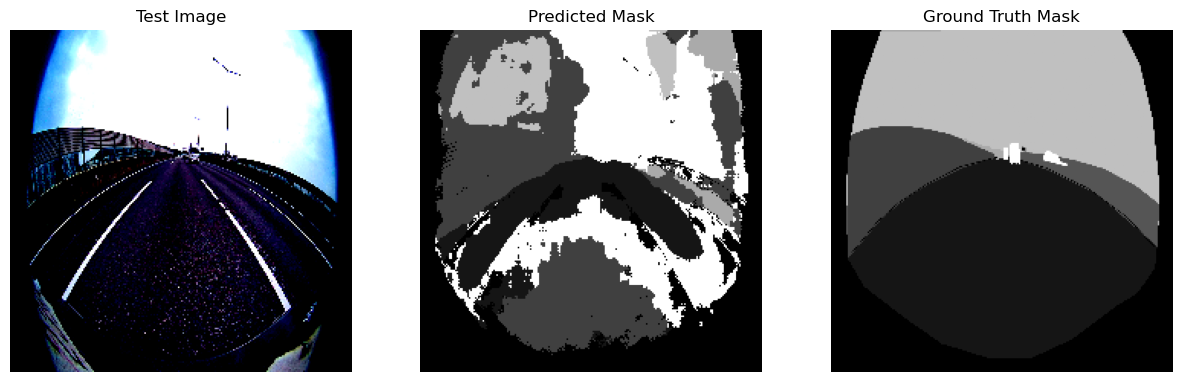

In [16]:
import matplotlib.pyplot as plt

# 시각화를 위한 코드
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지 시각화
aaa=target_images[0].permute(1, 2, 0).cpu().numpy()
a_fisheye = aaa[:,:,0]
axes[0].imshow(aaa, cmap='gray')
#axes[0].imshow(np.transpose(source_image[0].cpu().numpy(), (1, 2, 0)))
axes[0].set_title('Test Image')
axes[0].axis('off')

# 예측 결과 시각화
# pred_mask = torch.softmax(source_outputs[0], dim=1).cpu().numpy()
# pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()
axes[1].imshow(target_outputs[0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# 실제 마스크 시각화
axes[2].imshow(target_masks[0].cpu().numpy(), cmap='gray')
axes[2].set_title('Ground Truth Mask')
axes[2].axis('off')

plt.show()
